In [123]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt

In [124]:
cap = cv2.VideoCapture(0)

# capture one frame and conver to gray scale
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# release the capture handle
cap.release()

In [125]:
def reset_gray(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

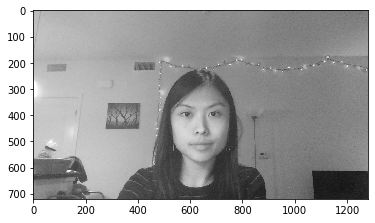

In [126]:
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [127]:
gray.shape

(720, 1280)

In [128]:
# front face detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../data/support/shape_predictor_68_face_landmarks.dat")
faces = detector(gray)

In [129]:
len(faces)

1

In [130]:
# for f in faces:
#     shape = predictor(gray, f)
#     for i in range(1,68): #There are 68 landmark points on each face
#         cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2)
#     plt.imshow(frame)

In [131]:
# extract the coordinates of landmarks
face1 = faces[0]

In [132]:
shape = predictor(gray, face1)
landmarks = np.asarray([(shape.part(i).x, shape.part(i).y) for i in range(68)])

In [133]:
# validate face landmark calculations
from collections import OrderedDict

In [134]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

In [135]:
# get left and right eye coordinates
(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
leftEyePts = landmarks[lStart:lEnd]
rightEyePts = landmarks[rStart:rEnd]
(leftEyePts, rightEyePts)

(array([[672, 403],
        [684, 391],
        [699, 389],
        [712, 396],
        [701, 403],
        [686, 404]]),
 array([[568, 397],
        [581, 390],
        [597, 392],
        [609, 403],
        [595, 406],
        [579, 405]]))

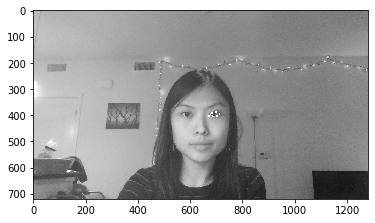

In [136]:
gray = reset_gray(frame)
for (x,y) in leftEyePts: #There are 68 landmark points on each face
    cv2.circle(gray, (x, y), 1, 255, thickness=5)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

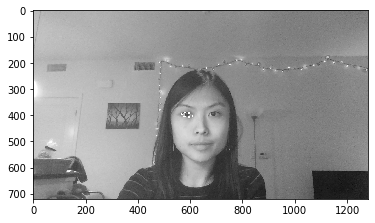

In [137]:
gray = reset_gray(frame)
for (x,y) in rightEyePts: #There are 68 landmark points on each face
    cv2.circle(gray, (x, y), 1, 255, thickness=5)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [138]:
# compute the center of mass for each eye
leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
(leftEyeCenter, rightEyeCenter)

(array([692, 397]), array([588, 398]))

In [139]:
# calculate the rotation angle
dY = rightEyeCenter[1] - leftEyeCenter[1]
dX = rightEyeCenter[0] - leftEyeCenter[0]
angle = np.degrees(np.arctan2(dY, dX)) - 180
(dY, dX, angle)

(1, -104, -0.5509039792185604)

In [140]:
dist1 = np.sqrt((dX ** 2) + (dY ** 2))
dist2 = np.linalg.norm(leftEyeCenter - rightEyeCenter)
dist1 == dist2

True

In [141]:
# calculate scale
desiredFaceWidth=256
desiredFaceHeight=256
desiredLeftEye=(0.35, 0.35)
dist = np.linalg.norm(leftEyeCenter - rightEyeCenter)
desiredDist = 1.0 - 2 * desiredLeftEye[0]
desiredDist *= desiredFaceWidth
scale = desiredDist / dist
scale

0.7384274033683332

In [142]:
eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2, (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
eyesCenter

(640, 397)

In [143]:
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
M

array([[ 7.38393270e-01, -7.09993529e-03,  1.70246982e+02],
       [ 7.09993529e-03,  7.38393270e-01,  9.93139133e+01]])

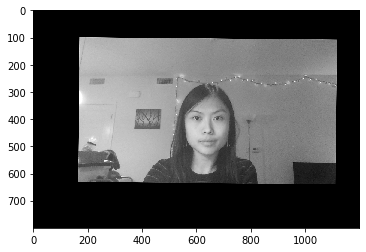

In [144]:
# use the original Affine matrix and see how we should do the translation
gray = reset_gray(frame)
output0 = cv2.warpAffine(gray, M, (1200, 800),flags=cv2.INTER_CUBIC)
plt.imshow(output0,cmap='gray', vmin=0, vmax=255)
plt.show()

In [145]:
# update the translation component of the matrix
'''
M = [A|B], where A is 2*2, and B is 2*1.
A is the rotation and scaling matrix (linear transformation),
B is the translation vector. 
Since eyesCenter's coordiantes do not change during the rotation and
scaling, we simply calculate the change of the eyescenter as the delta
for translation.
'''
tX = desiredFaceWidth * 0.5
tY = desiredFaceHeight * desiredLeftEye[1]
M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])
M

array([[ 7.38393270e-01, -7.09993529e-03, -3.41753018e+02],
       [ 7.09993529e-03,  7.38393270e-01, -2.08086087e+02]])

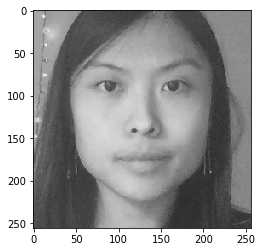

In [146]:
# apply the affine transformation
gray = reset_gray(frame)
(w, h) = (desiredFaceWidth, desiredFaceHeight)
output = cv2.warpAffine(gray, M, (w, h),flags=cv2.INTER_CUBIC)
plt.imshow(output,cmap='gray', vmin=0, vmax=255)
plt.show()

In [147]:
# calcuate the transformed cooridnates for landmarks

In [148]:
A = M[:, :2]; B = M[:, 2]
A, B

(array([[ 0.73839327, -0.00709994],
        [ 0.00709994,  0.73839327]]),
 array([-341.7530184 , -208.08608672]))

In [149]:
landmarks_ltfm = np.dot(A, landmarks.T)
landmarks_new = np.add(landmarks_ltfm.T, B)
landmarks_new_rounded = np.rint(landmarks_new).astype(int)

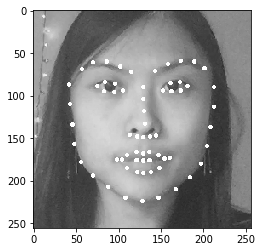

In [150]:
# circle transformed landmarks
for lm in landmarks_new_rounded: 
    cv2.circle(output, (lm[0], lm[1]), 1, (255,255,255), thickness=2)
plt.imshow(output, cmap='gray', vmin=0, vmax=255)
plt.show()